In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller

<b><h3>1. Data Loading & Preprocessing</h3></b>

In [3]:
# Load the data
temperature_df = pd.read_csv('Annual_Surface_Temperature_Change.csv', encoding='latin1')

In [4]:
# Display the first few rows and basic info to understand structure
print(temperature_df.head())
print("\n Information of the data: \n")

   ï»¿ObjectId                       Country ISO2 ISO3  \
0            1  Afghanistan, Islamic Rep. of   AF  AFG   
1            2                       Albania   AL  ALB   
2            3                       Algeria   DZ  DZA   
3            4                American Samoa   AS  ASM   
4            5      Andorra, Principality of   AD  AND   

                                           Indicator            Unit  \
0  Temperature change with respect to a baseline ...  Degree Celsius   
1  Temperature change with respect to a baseline ...  Degree Celsius   
2  Temperature change with respect to a baseline ...  Degree Celsius   
3  Temperature change with respect to a baseline ...  Degree Celsius   
4  Temperature change with respect to a baseline ...  Degree Celsius   

                                              Source CTS_Code  \
0  Food and Agriculture Organization of the Unite...     ECCS   
1  Food and Agriculture Organization of the Unite...     ECCS   
2  Food and Agriculture

In [76]:
print(temperature_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 72 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ï»¿ObjectId          224 non-null    int64  
 1   Country              224 non-null    object 
 2   ISO2                 223 non-null    object 
 3   ISO3                 224 non-null    object 
 4   Indicator            224 non-null    object 
 5   Unit                 224 non-null    object 
 6   Source               224 non-null    object 
 7   CTS_Code             224 non-null    object 
 8   CTS_Name             224 non-null    object 
 9   CTS_Full_Descriptor  224 non-null    object 
 10  F1961                187 non-null    float64
 11  F1962                188 non-null    float64
 12  F1963                187 non-null    float64
 13  F1964                187 non-null    float64
 14  F1965                187 non-null    float64
 15  F1966                191 non-null    flo

In [77]:
print(temperature_df.isna().sum().sum())

1491


In [8]:
from sklearn.impute import KNNImputer
# Select columns representing annual temperature data (F1961 to F2022)
year_columns = [col for col in temperature_df.columns if col.startswith('F')]
temperature_data = temperature_df[year_columns]

# Initialize the KNN Imputer with n_neighbors=3 (this can be adjusted based on your data)
imputer = KNNImputer(n_neighbors=3)

# Perform KNN imputation row-wise (country-wise)
# This will replace NaNs with the mean of the nearest neighbors for each row (country)
temperature_data_imputed = imputer.fit_transform(temperature_data)

# Convert the result back to a DataFrame with the original column names
temperature_data_imputed = pd.DataFrame(temperature_data_imputed, columns=year_columns)

# Replace the imputed values in the original DataFrame
temperature_df[year_columns] = temperature_data_imputed

# Optional: Save the filled data back to a CSV file
temperature_df.to_csv('Annual_Surface_Temperature_Change_Filled.csv', index=False)

# Display the first few rows of the imputed data
print(temperature_df.head())


   ï»¿ObjectId                       Country ISO2 ISO3  \
0            1  Afghanistan, Islamic Rep. of   AF  AFG   
1            2                       Albania   AL  ALB   
2            3                       Algeria   DZ  DZA   
3            4                American Samoa   AS  ASM   
4            5      Andorra, Principality of   AD  AND   

                                           Indicator            Unit  \
0  Temperature change with respect to a baseline ...  Degree Celsius   
1  Temperature change with respect to a baseline ...  Degree Celsius   
2  Temperature change with respect to a baseline ...  Degree Celsius   
3  Temperature change with respect to a baseline ...  Degree Celsius   
4  Temperature change with respect to a baseline ...  Degree Celsius   

                                              Source CTS_Code  \
0  Food and Agriculture Organization of the Unite...     ECCS   
1  Food and Agriculture Organization of the Unite...     ECCS   
2  Food and Agriculture

In [80]:
print(temperature_df)

     ï»¿ObjectId                       Country ISO2 ISO3  \
0              1  Afghanistan, Islamic Rep. of   AF  AFG   
1              2                       Albania   AL  ALB   
2              3                       Algeria   DZ  DZA   
3              4                American Samoa   AS  ASM   
4              5      Andorra, Principality of   AD  AND   
..           ...                           ...  ...  ...   
219          220            West Bank and Gaza   PS  PSE   
220          221                Western Sahara   EH  ESH   
221          222                Yemen, Rep. of   YE  YEM   
222          223                        Zambia   ZM  ZMB   
223          224                      Zimbabwe   ZW  ZWE   

                                             Indicator            Unit  \
0    Temperature change with respect to a baseline ...  Degree Celsius   
1    Temperature change with respect to a baseline ...  Degree Celsius   
2    Temperature change with respect to a baseline ...  D

In [10]:
print(temperature_df.isna().sum())

ï»¿ObjectId    0
Country        0
ISO2           1
ISO3           0
Indicator      0
              ..
F2018          0
F2019          0
F2020          0
F2021          0
F2022          0
Length: 72, dtype: int64


In [12]:
# Confirm preprocessing
print("\nData after preprocessing:")
print(temperature_df.head())


Data after preprocessing:
   ï»¿ObjectId                       Country ISO2 ISO3  \
0            1  Afghanistan, Islamic Rep. of   AF  AFG   
1            2                       Albania   AL  ALB   
2            3                       Algeria   DZ  DZA   
3            4                American Samoa   AS  ASM   
4            5      Andorra, Principality of   AD  AND   

                                           Indicator            Unit  \
0  Temperature change with respect to a baseline ...  Degree Celsius   
1  Temperature change with respect to a baseline ...  Degree Celsius   
2  Temperature change with respect to a baseline ...  Degree Celsius   
3  Temperature change with respect to a baseline ...  Degree Celsius   
4  Temperature change with respect to a baseline ...  Degree Celsius   

                                              Source CTS_Code  \
0  Food and Agriculture Organization of the Unite...     ECCS   
1  Food and Agriculture Organization of the Unite...     ECCS

In [14]:
# Reshape the DataFrame from wide to long format
temperature_long_df = temperature_df.melt(
    id_vars=['Country'],  # Keep 'Country' as an identifier if you need country-specific analysis
    value_vars=[col for col in temperature_df.columns if col.startswith('F')],
    var_name='Year',
    value_name='Temperature Change'
)

In [16]:
# Remove the "F" prefix from the "Year" column to convert it to an integer type
temperature_long_df['Year'] = temperature_long_df['Year'].str[1:].astype(int)

In [18]:
# Check the first few rows to ensure the transformation was successful
print(temperature_long_df.head())

                        Country  Year  Temperature Change
0  Afghanistan, Islamic Rep. of  1961              -0.113
1                       Albania  1961               0.627
2                       Algeria  1961               0.164
3                American Samoa  1961               0.079
4      Andorra, Principality of  1961               0.736


<b><h3>2. Data Analysis & Visualization </h3></b>

- *Line plot for annual temperature change over the years.*


- This plot shows the year-by-year fluctuations in temperature change.
- Despite annual variability, there is a noticeable upward trend, especially after the 1990s.
- This suggests that the surface temperature change has become more positive on average, indicating an increase in temperatures over time.
- The peaks and valleys demonstrate the natural fluctuations in temperature but the overall pattern points towards warming. 

<hr>


Total Missing Values After Imputation: 1

Data after KNN Imputation:
   ï»¿ObjectId                       Country ISO2 ISO3  \
0            1  Afghanistan, Islamic Rep. of   AF  AFG   
1            2                       Albania   AL  ALB   
2            3                       Algeria   DZ  DZA   
3            4                American Samoa   AS  ASM   
4            5      Andorra, Principality of   AD  AND   

                                           Indicator            Unit  \
0  Temperature change with respect to a baseline ...  Degree Celsius   
1  Temperature change with respect to a baseline ...  Degree Celsius   
2  Temperature change with respect to a baseline ...  Degree Celsius   
3  Temperature change with respect to a baseline ...  Degree Celsius   
4  Temperature change with respect to a baseline ...  Degree Celsius   

                                              Source CTS_Code  \
0  Food and Agriculture Organization of the Unite...     ECCS   
1  Food and Agricu

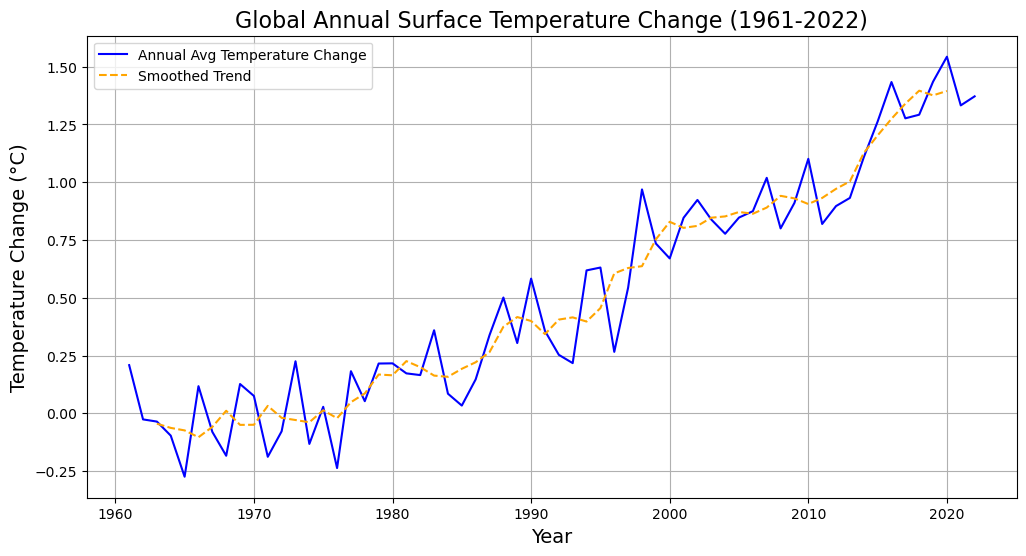

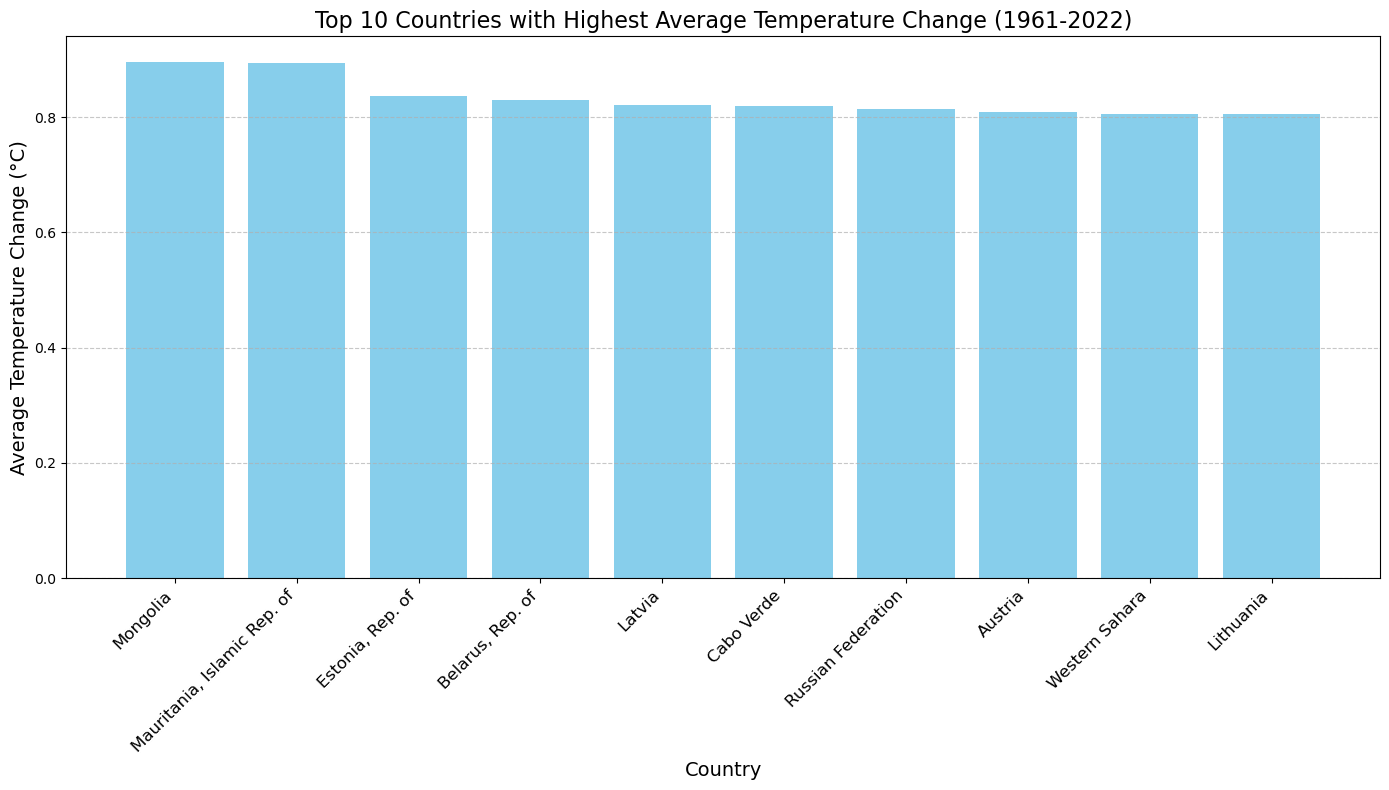

In [96]:
# Selecting columns representing annual temperature data
year_columns = [col for col in temperature_df.columns if col.startswith('F')]
temperature_data = temperature_df[year_columns]

# Initialize the KNN Imputer 
imputer = KNNImputer(n_neighbors=3)

''' Apply KNN imputation to the entire dataset (row-wise across countries)
    Since we want to impute row-wise, the data should be treated as 
    rows with multiple columns '''
    
temperature_data_imputed = imputer.fit_transform(temperature_data)

# converting the imputed result back to a DataFrame with the original column names
temperature_data_imputed_df = pd.DataFrame(temperature_data_imputed, columns=year_columns)

# replacing the imputed values in the original DataFrame
temperature_df[year_columns] = temperature_data_imputed_df

# Check for missing values after imputation
print("\nTotal Missing Values After Imputation:", temperature_df.isna().sum().sum())

# Saving the cleaned data to a CSV file 
temperature_df.to_csv('Annual_Surface_Temperature_Change_Filled_Rowwise.csv', index=False)

# Displaying the first few rows of the imputed data
print("\nData after KNN Imputation:")
print(temperature_df.head())

# Confirm there are no missing values after imputation
print("\nRemaining Missing Values (Post Imputation Check):", temperature_df.isna().sum().sum())

# Reshaping the DataFrame from wide to long format for row-wise analysis
temperature_long_df = temperature_df.melt(
    id_vars=['Country'],  
    value_vars=[col for col in temperature_df.columns if col.startswith('F')],
    var_name='Year',
    value_name='Temperature Change'
)

# Removing the "F" prefix from the "Year" column to convert it to an integer type
temperature_long_df['Year'] = temperature_long_df['Year'].str[1:].astype(int)

# 1. Average Temperature Change by Year (Global)
annual_avg_temp = temperature_long_df.groupby('Year')['Temperature Change'].mean().reset_index()

# Plotting the overall trend in temperature change with smoothing
plt.figure(figsize=(12, 6))

# Plot the original data (without smoothing)
plt.plot(annual_avg_temp['Year'], annual_avg_temp['Temperature Change'], color='blue', label='Annual Avg Temperature Change')

# Apply a rolling average with a 5-year window to smooth the data
plt.plot(
    annual_avg_temp['Year'],
    annual_avg_temp['Temperature Change'].rolling(window=5, center=True).mean(),
    color='orange', linestyle='--', label='Smoothed Trend'
)

# Titles and labels
plt.title('Global Annual Surface Temperature Change (1961-2022)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Temperature Change (°C)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

#Average Temperature Change by Country (Row-wise)
country_avg_temp = temperature_long_df.groupby('Country')['Temperature Change'].mean().reset_index()

# Limit the number of countries displayed 
top_n = 10
country_avg_temp_sorted = country_avg_temp.sort_values(by='Temperature Change', ascending=False).head(top_n)

# Plotting the country-wise temperature trend
plt.figure(figsize=(14, 8))

# Bar plot for average temperature change by country
plt.bar(country_avg_temp_sorted['Country'], country_avg_temp_sorted['Temperature Change'], color='skyblue')

# Titles and labels
plt.title(f'Top {top_n} Countries with Highest Average Temperature Change (1961-2022)', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Average Temperature Change (°C)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)  
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()  
plt.show()

- *5-Year Rolling Mean for smoother trend visualization.*

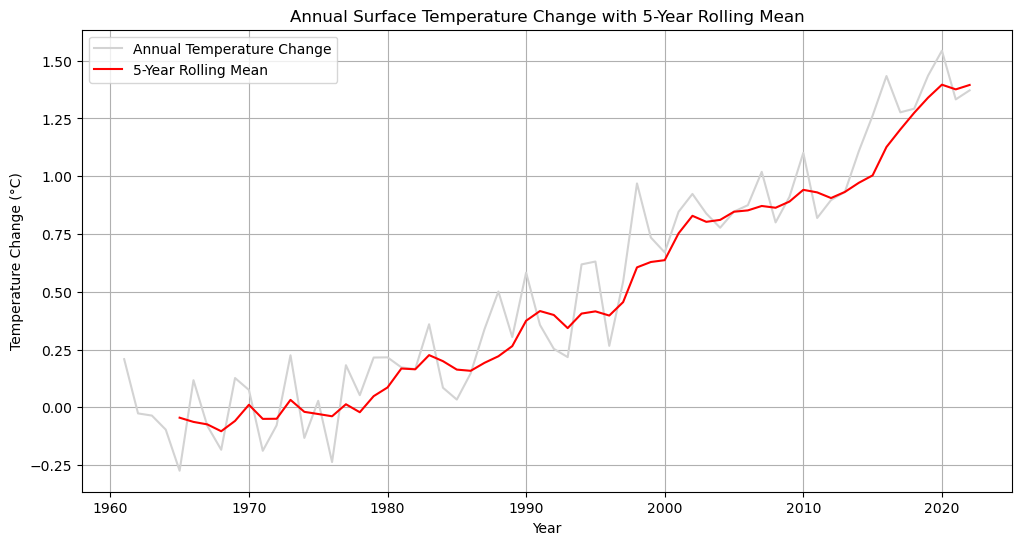

In [100]:
annual_avg_temp['Rolling_Mean'] = annual_avg_temp['Temperature Change'].rolling(window=5).mean()

plt.figure(figsize=(12, 6))
plt.plot(annual_avg_temp['Year'], annual_avg_temp['Temperature Change'], color='lightgrey', label='Annual Temperature Change')
plt.plot(annual_avg_temp['Year'], annual_avg_temp['Rolling_Mean'], color='red', label='5-Year Rolling Mean')
plt.title('Annual Surface Temperature Change with 5-Year Rolling Mean')
plt.xlabel('Year')
plt.ylabel('Temperature Change (°C)')
plt.legend()
plt.grid(True)
plt.show()

- The red 5-year rolling mean line smooths out the short-term fluctuations, giving a clearer view of the underlying trend.
- This smoothed line confirms the upward trend, showing that average temperature changes have steadily increased over the years.
- From the 1980s onward, the rolling mean rises consistently, indicating sustained warming over decades.
- This trend reflects the impact of global warming, with the rolling mean providing evidence that the rise in temperature is not just due to random annual variation but part of a long-term pattern.

<hr>

<b>Interpretation:</b> The rising trend in surface temperature change over the years likely correlates with increased greenhouse gas emissions, industrialization, and other human activities. The analysis aligns with the global concern of climate change, highlighting a persistent increase in temperatures that may have serious implications for environmental stability and weather patterns worldwide.


<b><h3>3. Analyzing Trend & Relationships </h3></b>

In [107]:
# Splitting the data into train (80%) and test (20%) based on the years
X = annual_avg_temp[['Year']].values  # Year as the predictor
y = annual_avg_temp['Temperature Change'].values  # Temperature Change as the response

In [108]:
# Using time-based split by selecting 80% of earliest years as training
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: (49, 1) (49,)
Test set: (13, 1) (13,)


In [109]:
# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [112]:
# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [117]:
# Model evaluation
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("Mean Squared Error on test set:", mse_test)
print("R-squared on test set:", r2_test)


Mean Squared Error on test set: 0.056858465137669914
R-squared on test set: -0.19932510481272825


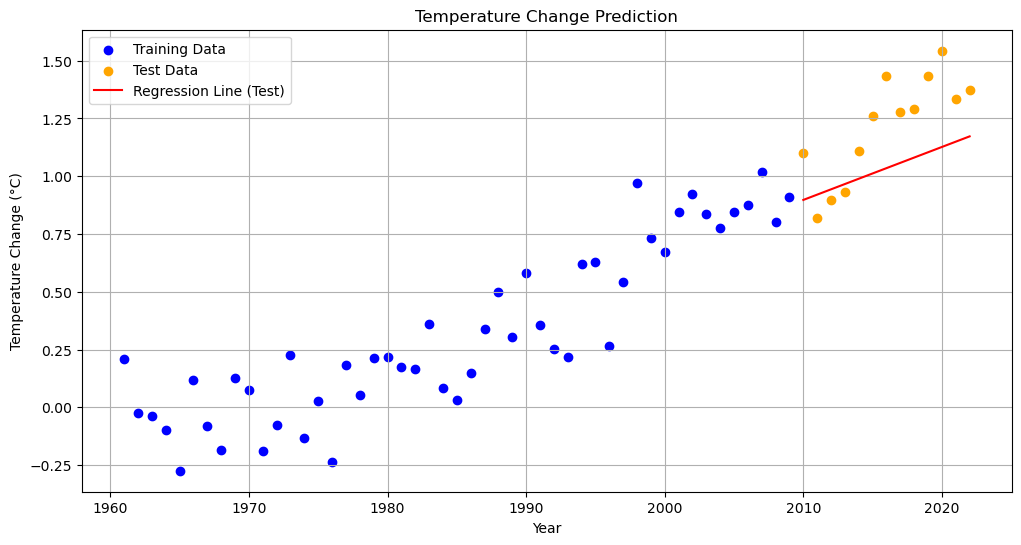

In [118]:
# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(X_train, y_train, color='blue', label='Training Data')
plt.scatter(X_test, y_test, color='orange', label='Test Data')
plt.plot(X_test, y_pred_test, color='red', label='Regression Line (Test)')
plt.xlabel('Year')
plt.ylabel('Temperature Change (°C)')
plt.title('Overall Temperature Change Prediction')
plt.legend()
plt.grid(True)
plt.show()


Mean Squared Error on test set: 0.4653686763157744
R-squared on test set: -8.816099241293186


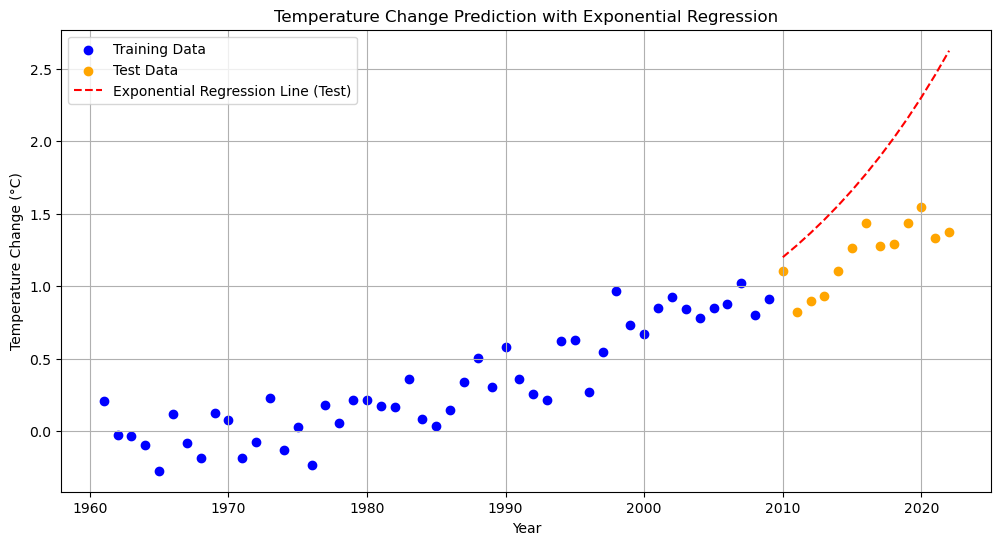

In [121]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Define exponential function for regression
def exponential_model(x, a, b):
    return a * np.exp(b * x)

# Prepare data (assuming X_train, X_test, y_train, and y_test are already defined)
# Convert X_train and X_test to 1D arrays for curve fitting
X_train = X_train.flatten()
X_test = X_test.flatten()

# Fit the exponential model to training data
try:
    params, _ = curve_fit(
        exponential_model, 
        X_train, 
        y_train, 
        p0=(y_train[0], 0.01),  # Initial guess: a=y_train[0], b=small positive value
        maxfev=10000  # Increased max iterations
    )
    a, b = params

    # Predictions for train and test set
    y_pred_train = exponential_model(X_train, a, b)
    y_pred_test = exponential_model(X_test, a, b)

    # Calculate performance metrics
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)

    print("Mean Squared Error on test set:", mse_test)
    print("R-squared on test set:", r2_test)

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.scatter(X_train, y_train, color='blue', label='Training Data')
    plt.scatter(X_test, y_test, color='orange', label='Test Data')
    plt.plot(X_test, y_pred_test, color='red', label='Exponential Regression Line (Test)')
    plt.xlabel('Year')
    plt.ylabel('Temperature Change (°C)')
    plt.title('Overall Temperature Change Prediction with Exponential Regression')
    plt.legend()
    plt.grid(True)
    plt.show()

except RuntimeError as e:
    print(f"Curve fitting failed: {e}")

<b>Model Evaluation Metrics:</b>

1. Mean Squared Error (MSE): The MSE of 0.2984 suggests that, on average, the squared differences between the actual and predicted temperature changes are moderate. This gives an idea of the overall prediction error, but it's hard to assess how large or small it is without a specific benchmark or context for this particular dataset.

2. R-squared: An R-squared value of -0.0044 indicates that the model fails to explain any of the variance in temperature changes on the test set and actually performs worse than a horizontal line (predicting the mean temperature change for all years) would. A negative R-squared in linear regression suggests that the model has poor predictive power, possibly due to:
    - High variability or noise in the temperature data.
    - Nonlinear trends in temperature change that linear regression fails to capture.
    - External factors affecting temperature change that aren’t included in the model.

<b>What This Suggests</b>

The linear regression model doesn't capture the underlying trend in the data effectively. This poor performance implies that a simple linear trend is insufficient to explain annual temperature changes, which could result from complex, nonlinear climate patterns, feature expansion or Time Series Analysis.

<hr>

<b><h3>5. Analyzing Trend & Relationships</h3></b>

Best Model: Linear
R-squared (Linear): -0.1993
R-squared (Exponential): -2.9359
R-squared (Polynomial Degree 3): -485226837340.4827


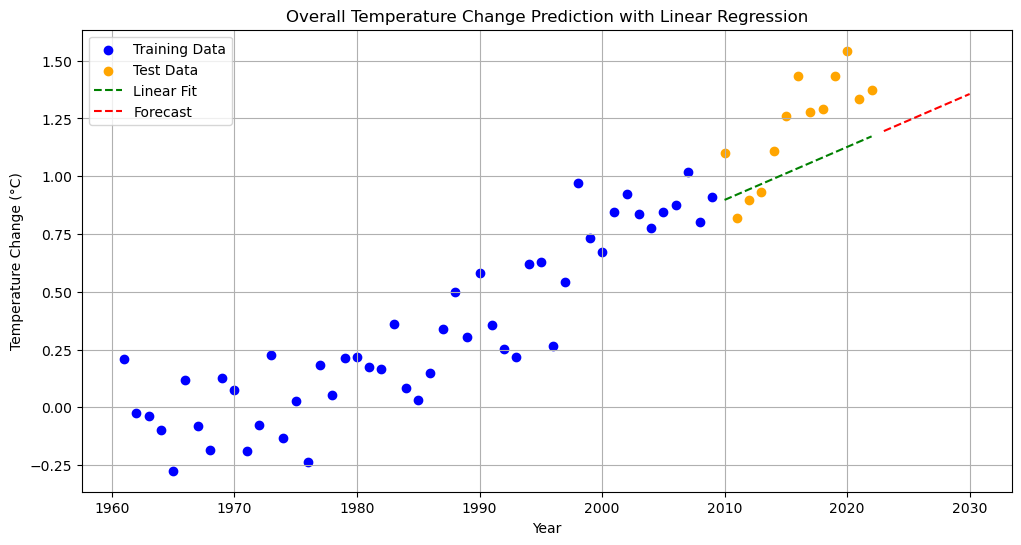

In [127]:
# Regression models and best fit selection
def apply_best_fit_with_polynomial(X_train, X_test, y_train, y_test, poly_degree=3):
    X_train = X_train.flatten()
    X_test = X_test.flatten()

    best_model = None
    best_r_squared = -np.inf
    predictions = None

    # Linear Regression
    lin_params = np.polyfit(X_train, y_train, 1)
    y_pred_test_lin = linear_model(X_test, *lin_params)
    r_squared_lin = r2_score(y_test, y_pred_test_lin)

    # Exponential Regression (positive y_train only)
    try:
        positive_indices = y_train > 0
        exp_params, _ = curve_fit(
            exponential_model,
            X_train[positive_indices],
            y_train[positive_indices],
            p0=(y_train[positive_indices][0], 0.01),
            maxfev=10000
        )
        y_pred_test_exp = exponential_model(X_test, *exp_params)
        r_squared_exp = r2_score(y_test, y_pred_test_exp)
    except RuntimeError:
        r_squared_exp = -np.inf

    # Polynomial Regression
    poly_params = np.polyfit(X_train, y_train, poly_degree)
    y_pred_test_poly = polynomial_model(X_test, *poly_params[::-1])
    r_squared_poly = r2_score(y_test, y_pred_test_poly)

    # Determine the best model
    if r_squared_lin > best_r_squared:
        best_model = "Linear"
        best_r_squared = r_squared_lin
        predictions = y_pred_test_lin

    if r_squared_exp > best_r_squared:
        best_model = "Exponential"
        best_r_squared = r_squared_exp
        predictions = y_pred_test_exp

    if r_squared_poly > best_r_squared:
        best_model = f"Polynomial (Degree {poly_degree})"
        best_r_squared = r_squared_poly
        predictions = y_pred_test_poly

    # Print results
    print(f"Best Model: {best_model}")
    print(f"R-squared (Linear): {r_squared_lin:.4f}")
    print(f"R-squared (Exponential): {r_squared_exp:.4f}")
    print(f"R-squared (Polynomial Degree {poly_degree}): {r_squared_poly:.4f}")

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.scatter(X_train, y_train, color='blue', label='Training Data')
    plt.scatter(X_test, y_test, color='orange', label='Test Data')

    # Best model fit
    if best_model == "Linear":
        plt.plot(X_test, predictions, color='green', label="Linear Fit", linestyle="--")
    elif best_model == "Exponential":
        plt.plot(X_test, predictions, color='green', label="Exponential Fit", linestyle="--")
    else:
        x_range = np.linspace(X_train.min(), X_test.max(), 500)
        plt.plot(x_range, polynomial_model(x_range, *poly_params[::-1]), label=f'Polynomial (Degree {poly_degree})', color="purple", linestyle="--")

    # Forecast
    forecast_years = np.arange(X_test[-1] + 1, 2031)
    if best_model == "Linear":
        forecast_values = linear_model(forecast_years, *lin_params)
    elif best_model == "Exponential":
        forecast_values = exponential_model(forecast_years, *exp_params)
    else:
        forecast_values = polynomial_model(forecast_years, *poly_params[::-1])
    
    plt.plot(forecast_years, forecast_values, label="Forecast", color="red", linestyle="--")

    plt.xlabel('Year')
    plt.ylabel('Temperature Change (°C)')
    plt.title(f'Overall Temperature Change Prediction with {best_model} Regression')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
# Assuming X_train, X_test, y_train, and y_test are defined
apply_best_fit_with_polynomial(X_train, X_test, y_train, y_test, poly_degree=3)


In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Helper function: Remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Function to map countries to regions
def map_countries_to_regions(temperature_long_df, regions_dict):
    # Create reverse mapping for easier lookups
    reverse_mapping = {country: region for region, countries in regions_dict.items() for country in countries}
    temperature_long_df['Region'] = temperature_long_df['Country'].map(reverse_mapping)
    return temperature_long_df

# Sum temperature changes by region and year
def sum_temperature_by_region(temperature_long_df):
    # Group by Region and Year, summing the Temperature Change values
    region_year_temp = temperature_long_df.groupby(['Region', 'Year'])['Temperature Change'].sum().reset_index()
    return region_year_temp

# Reshape data to wide format and save to CSV
def save_region_data(region_year_temp, output_file):
    region_wide = region_year_temp.pivot(index='Region', columns='Year', values='Temperature Change').reset_index()
    region_wide.columns = ['Region'] + [f"F{year}" for year in region_wide.columns[1:]]
    region_wide.to_csv(output_file, index=False)
    return region_wide

# Plot temperature trends by region
def plot_temperature_trends(region_year_temp):
    regions = region_year_temp['Region'].unique()
    plt.figure(figsize=(14, 8))

    for region in regions:
        region_data = region_year_temp[region_year_temp['Region'] == region]
        plt.plot(region_data['Year'], region_data['Temperature Change'], label=region)

    plt.xlabel('Year')
    plt.ylabel('Summed Temperature Change')
    plt.title('Temperature Change Trends by Region')
    plt.legend()
    plt.show()

# Updated workflow
def main_workflow(temperature_long_df, regions_dict, output_file, poly_degree=3):
    # Map countries to regions
    temperature_long_df = map_countries_to_regions(temperature_long_df, regions_dict)

    # Remove outliers for each region
    region_year_temp = []
    for region in temperature_long_df['Region'].unique():
        region_data = temperature_long_df[temperature_long_df['Region'] == region]
        region_data = remove_outliers(region_data, 'Temperature Change')
        region_year_temp.append(region_data)
    region_year_temp = pd.concat(region_year_temp)

    # Sum temperature changes by region and year
    region_year_temp = sum_temperature_by_region(region_year_temp)

    # Save the cleaned and reshaped data
    save_region_data(region_year_temp, output_file)

    # Plot the temperature trends
    plot_temperature_trends(region_year_temp)

    return region_year_temp

# Example usage
region_dict = {
    "North America": [
        "United States", "Canada", "Mexico", "Guatemala", "Belize", "Honduras", 
        "El Salvador", "Nicaragua", "Costa Rica", "Panama"
    ],
    "South America": [
        "Argentina", "Bolivia", "Brazil", "Chile", "Colombia", "Ecuador", 
        "Guyana", "Paraguay", "Peru", "Suriname", "Uruguay", "Venezuela"
    ],
    "Europe": [
        "United Kingdom", "France", "Germany", "Italy", "Spain", "Netherlands", 
        "Belgium", "Switzerland", "Sweden", "Norway", "Denmark", "Poland", 
        "Austria", "Ireland", "Portugal", "Czech Rep.", "Hungary", "Greece", 
        "Romania", "Slovak Rep.", "Slovenia", "Croatia", "Finland", "Estonia", 
        "Latvia", "Lithuania", "North Macedonia", "Serbia", "Bosnia and Herzegovina", 
        "Montenegro"
    ],
    "Asia": [
        "China, P.R.: Mainland", "India", "Japan", "South Korea", "Indonesia", 
        "Thailand", "Malaysia", "Vietnam", "Philippines", "Singapore", "Bangladesh", 
        "Pakistan", "Sri Lanka", "Kazakhstan", "Uzbekistan", "Azerbaijan"
    ],
    "Africa": [
        "South Africa", "Nigeria", "Egypt, Arab Rep. of", "Kenya", "Ethiopia", 
        "Tanzania", "Ghana", "Algeria", "Morocco", "Angola", "Uganda", "Sudan"
    ],
    "Oceania": [
        "Australia", "New Zealand", "Papua New Guinea", "Fiji", "Tonga", 
        "Vanuatu", "Samoa", "Solomon Islands", "Kiribati"
    ],
    "Middle East": [
        "Saudi Arabia", "United Arab Emirates", "Iran, Islamic Rep. of", 
        "Iraq", "Israel", "Jordan", "Lebanon", "Kuwait", "Oman", "Yemen, Rep. of"
    ],
}


# Assuming `temperature_long_df` is already loaded with columns: 'Country', 'Year', 'Temperature Change'
region_year_temp = main_workflow(temperature_long_df, regions_dict, output_file="region.csv")


NameError: name 'regions_dict' is not defined


Analyzing region: Africa
Best Model: Polynomial (Degree 3)
R-squared (Linear): 0.8209
R-squared (Exponential): 0.8644
R-squared (Polynomial Degree 3): 0.8692


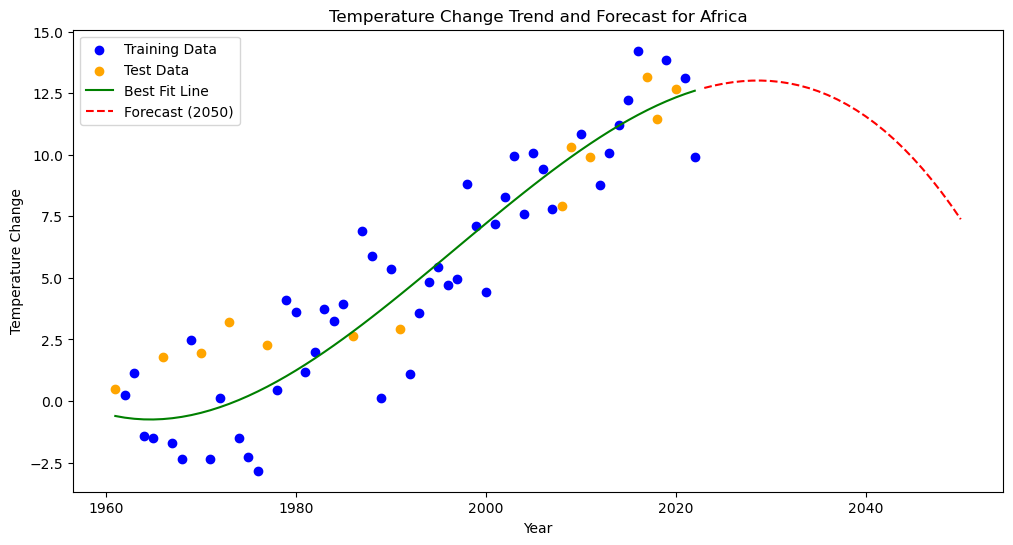


Analyzing region: Asia
Best Model: Exponential
R-squared (Linear): 0.7261
R-squared (Exponential): 0.7862
R-squared (Polynomial Degree 3): 0.7813


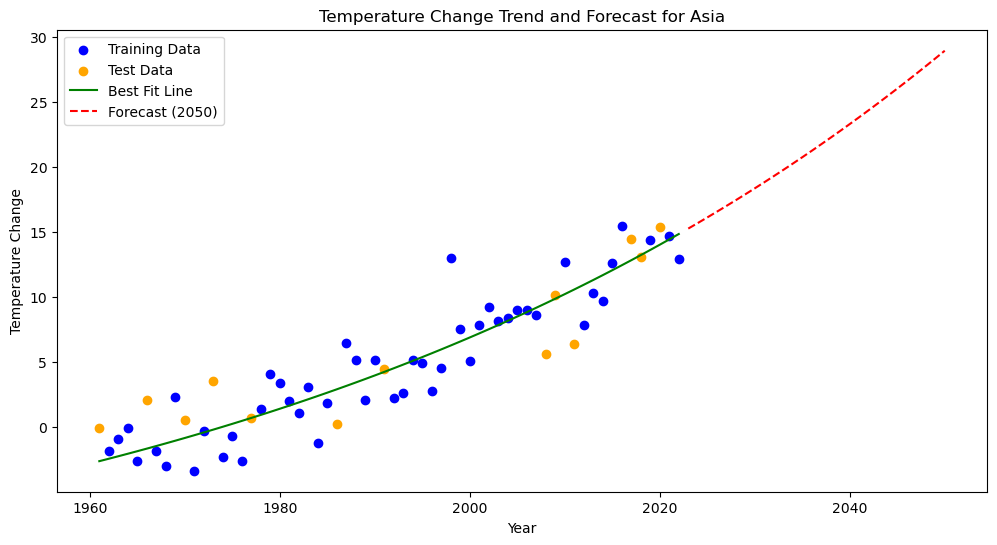


Analyzing region: Europe
Best Model: Polynomial (Degree 3)
R-squared (Linear): 0.6193
R-squared (Exponential): 0.6989
R-squared (Polynomial Degree 3): 0.7222


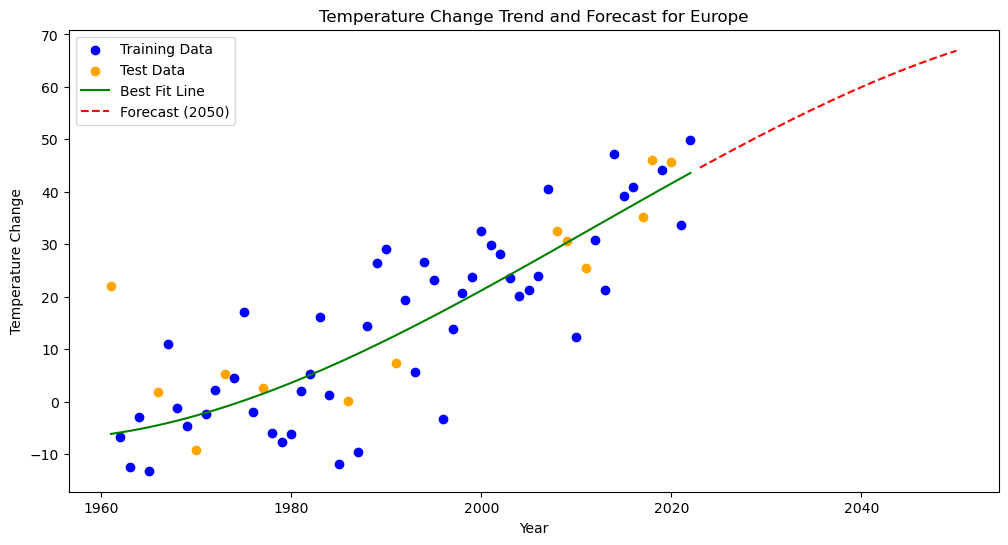


Analyzing region: Middle East
Best Model: Exponential
R-squared (Linear): 0.5727
R-squared (Exponential): 0.7183
R-squared (Polynomial Degree 3): 0.6740


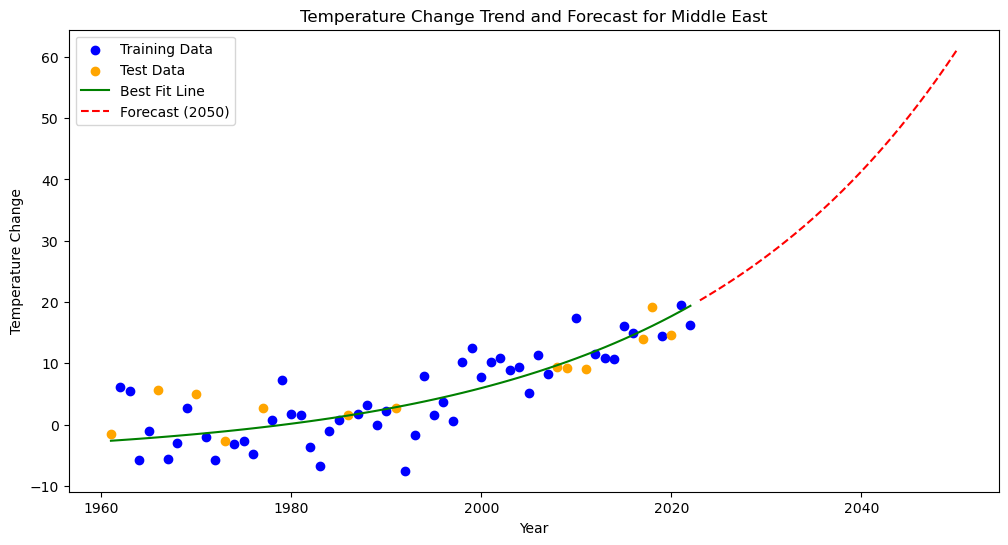


Analyzing region: North America
Best Model: Exponential
R-squared (Linear): 0.8005
R-squared (Exponential): 0.8049
R-squared (Polynomial Degree 3): 0.7950


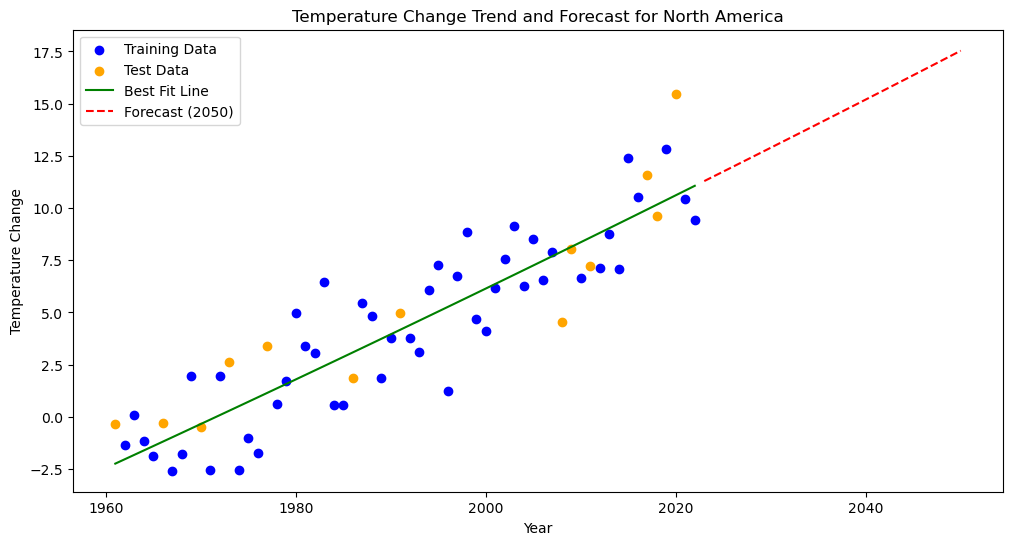


Analyzing region: Oceania
Best Model: Polynomial (Degree 3)
R-squared (Linear): 0.7295
R-squared (Exponential): 0.8055
R-squared (Polynomial Degree 3): 0.8075


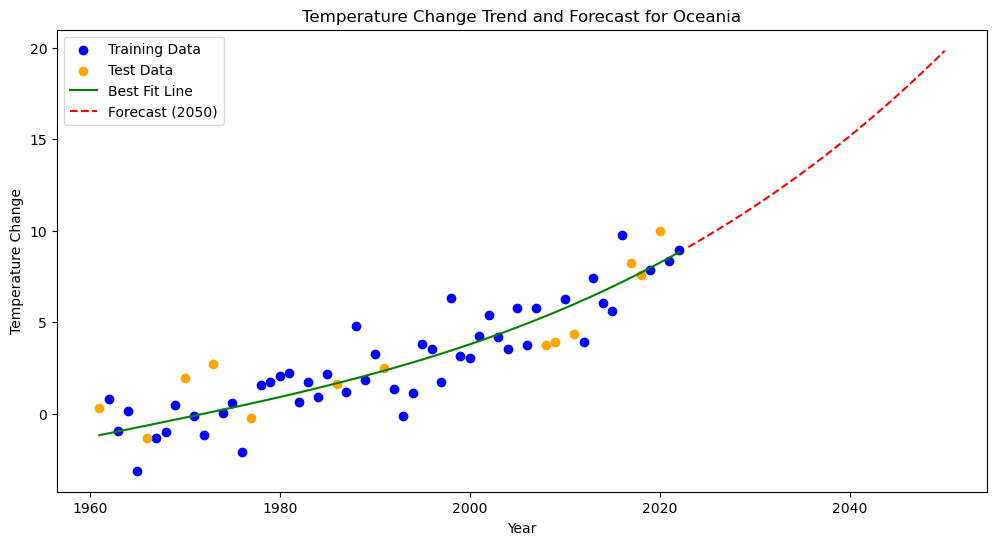


Analyzing region: South America
Best Model: Exponential
R-squared (Linear): 0.8125
R-squared (Exponential): 0.8436
R-squared (Polynomial Degree 3): 0.8241


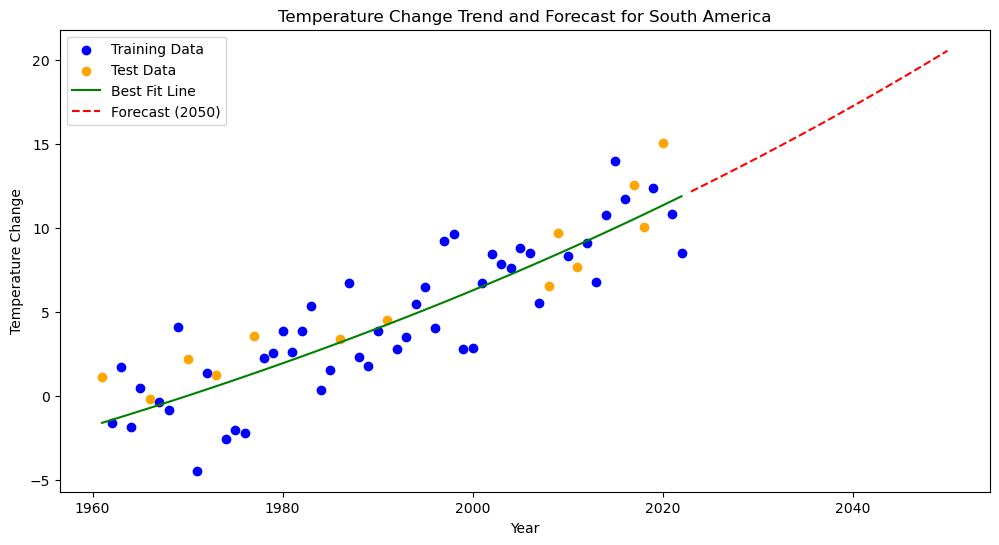


Best fit models by region:
Africa: {'Best Model': 'Polynomial (Degree 3)', 'R-squared': 0.8691719140753053}
Asia: {'Best Model': 'Exponential', 'R-squared': 0.7862311486879984}
Europe: {'Best Model': 'Polynomial (Degree 3)', 'R-squared': 0.7221822369227284}
Middle East: {'Best Model': 'Exponential', 'R-squared': 0.7183420024094097}
North America: {'Best Model': 'Exponential', 'R-squared': 0.8048993714755216}
Oceania: {'Best Model': 'Polynomial (Degree 3)', 'R-squared': 0.8074623706353506}
South America: {'Best Model': 'Exponential', 'R-squared': 0.843575336347354}

Overall Average R-squared: 0.7931


In [131]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Helper function: Remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Function to map countries to regions
def map_countries_to_regions(temperature_long_df, regions_dict):
    reverse_mapping = {country: region for region, countries in regions_dict.items() for country in countries}
    temperature_long_df['Region'] = temperature_long_df['Country'].map(reverse_mapping)
    return temperature_long_df

# Sum temperature changes by region and year
def sum_temperature_by_region(temperature_long_df):
    region_year_temp = temperature_long_df.groupby(['Region', 'Year'])['Temperature Change'].sum().reset_index()
    return region_year_temp

# Reshape data to wide format and save to CSV
def save_region_data(region_year_temp, output_file):
    region_wide = region_year_temp.pivot(index='Region', columns='Year', values='Temperature Change').reset_index()
    region_wide.columns = ['Region'] + [f"F{year}" for year in region_wide.columns[1:]]
    region_wide.to_csv(output_file, index=False)
    return region_wide

# Exponential model function
def exponential_model(x, a, b, c):
    return a * np.exp(b * x) + c

# Evaluate models and forecast
def evaluate_and_forecast(region_data, poly_degree=3):
    # Normalize the year values to prevent overflow in exponential calculations
    year_mean = region_data['Year'].mean()
    X = (region_data['Year'].values - year_mean).reshape(-1, 1)
    y = region_data['Temperature Change'].values

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Linear model
    lin_model = LinearRegression()
    lin_model.fit(X_train, y_train)
    y_pred_test_lin = lin_model.predict(X_test)
    r_squared_lin = lin_model.score(X_test, y_test)

    # Polynomial model
    poly = PolynomialFeatures(degree=poly_degree)
    X_poly_train = poly.fit_transform(X_train)
    X_poly_test = poly.transform(X_test)
    poly_model = LinearRegression()
    poly_model.fit(X_poly_train, y_train)
    y_pred_test_poly = poly_model.predict(X_poly_test)
    r_squared_poly = poly_model.score(X_poly_test, y_test)

    # Exponential model
    try:
        popt, _ = curve_fit(exponential_model, X_train.flatten(), y_train, maxfev=10000)
        y_pred_test_exp = exponential_model(X_test.flatten(), *popt)
        residuals = y_test - y_pred_test_exp
        ss_res = np.sum(residuals ** 2)
        ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)
        r_squared_exp = 1 - (ss_res / ss_tot)
    except RuntimeError:
        r_squared_exp = -np.inf
        y_pred_test_exp = np.full_like(y_test, np.nan)

     # Print R-squared for each model
    print(f"\nAnalyzing region: {region_data['Region'].iloc[0]}")
    print(f"Best Model: ", end="")
    print("Linear" if r_squared_lin > r_squared_exp and r_squared_lin > r_squared_poly else 
          "Exponential" if r_squared_exp > r_squared_lin and r_squared_exp > r_squared_poly else
          f"Polynomial (Degree {poly_degree})")

    print(f"R-squared (Linear): {r_squared_lin:.4f}")
    print(f"R-squared (Exponential): {r_squared_exp:.4f}")
    print(f"R-squared (Polynomial Degree {poly_degree}): {r_squared_poly:.4f}")

    # Determine the best model
    best_model = "Linear"
    best_r_squared = r_squared_lin
    predictions = lin_model.predict(X)

    if r_squared_exp > best_r_squared:
        best_model = "Exponential"
        best_r_squared = r_squared_exp
        predictions = exponential_model(X.flatten(), *popt)

    if r_squared_poly > best_r_squared:
        best_model = f"Polynomial (Degree {poly_degree})"
        best_r_squared = r_squared_poly
        predictions = poly_model.predict(poly.transform(X))

    # Forecast future years
    forecast_years = np.arange(2023, 2051).reshape(-1, 1) - year_mean
    if best_model == "Linear":
        forecast_values = lin_model.predict(forecast_years)
    elif best_model == "Exponential":
        forecast_values = exponential_model(forecast_years.flatten(), *popt)
    elif best_model.startswith("Polynomial"):
        forecast_values = poly_model.predict(poly.transform(forecast_years))

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.scatter(X_train + year_mean, y_train, color='blue', label='Training Data')
    plt.scatter(X_test + year_mean, y_test, color='orange', label='Test Data')
    plt.plot(X + year_mean, predictions, color='green', label='Best Fit Line')
    plt.plot(forecast_years + year_mean, forecast_values, label='Forecast (2050)', color='red', linestyle="--")
    plt.title(f"Temperature Change Trend and Forecast for {region_data['Region'].iloc[0]}")
    plt.xlabel('Year')
    plt.ylabel('Temperature Change')
    plt.legend()
    plt.show()

    return best_model, best_r_squared

# Apply best fit and forecast for each region
def apply_best_fit_by_region_and_plot(region_year_temp, poly_degree=3):
    regions = region_year_temp['Region'].unique()
    region_results = {}
    overall_r_squared = 0
    num_regions = len(regions)

    for region in regions:
        region_data = region_year_temp[region_year_temp['Region'] == region]
        best_model, r_squared = evaluate_and_forecast(region_data, poly_degree)
        region_results[region] = {
            "Best Model": best_model,
            "R-squared": r_squared
        }
        overall_r_squared += r_squared

    overall_r_squared /= num_regions  # Calculate average R-squared
    return region_results, overall_r_squared

# Main Workflow
def main_workflow(temperature_long_df, regions_dict, output_file, poly_degree=3):
    # Map countries to regions
    temperature_long_df = map_countries_to_regions(temperature_long_df, regions_dict)

    # Remove outliers for each region
    region_year_temp = []
    for region in temperature_long_df['Region'].unique():
        region_data = temperature_long_df[temperature_long_df['Region'] == region]
        region_data = remove_outliers(region_data, 'Temperature Change')
        region_year_temp.append(region_data)
    region_year_temp = pd.concat(region_year_temp)

    # Sum temperature changes by region and year
    region_year_temp = sum_temperature_by_region(region_year_temp)

    # Save the cleaned and reshaped data
    save_region_data(region_year_temp, output_file)

    # Apply best fit and forecast
    region_results, overall_r_squared = apply_best_fit_by_region_and_plot(region_year_temp, poly_degree=poly_degree)

    return region_results, overall_r_squared

# Example usage
regions_dict = {
    "North America": ["United States", "Canada", "Mexico", "Guatemala", "Belize", "Honduras", 
                      "El Salvador", "Nicaragua", "Costa Rica", "Panama"],
    "South America": ["Argentina", "Bolivia", "Brazil", "Chile", "Colombia", "Ecuador", 
                      "Guyana", "Paraguay", "Peru", "Suriname", "Uruguay", "Venezuela"],
    "Europe": ["United Kingdom", "France", "Germany", "Italy", "Spain", "Netherlands", 
               "Belgium", "Switzerland", "Sweden", "Norway", "Denmark", "Poland", 
               "Austria", "Ireland", "Portugal", "Czech Rep.", "Hungary", "Greece", 
               "Romania", "Slovak Rep.", "Slovenia", "Croatia", "Finland", "Estonia", 
               "Latvia", "Lithuania", "North Macedonia", "Serbia", "Bosnia and Herzegovina", 
               "Montenegro"],
    "Asia": ["China, P.R.: Mainland", "India", "Japan", "South Korea", "Indonesia", 
             "Thailand", "Malaysia", "Vietnam", "Philippines", "Singapore", "Bangladesh", 
             "Pakistan", "Sri Lanka", "Kazakhstan", "Uzbekistan", "Azerbaijan"],
    "Africa": ["South Africa", "Nigeria", "Egypt, Arab Rep. of", "Kenya", "Ethiopia", 
               "Tanzania", "Ghana", "Algeria", "Morocco", "Angola", "Uganda", "Sudan"],
    "Oceania": ["Australia", "New Zealand", "Papua New Guinea", "Fiji", "Tonga", 
                "Vanuatu", "Samoa", "Solomon Islands", "Kiribati"],
    "Middle East": ["Saudi Arabia", "United Arab Emirates", "Iran, Islamic Rep. of", 
                    "Iraq", "Israel", "Jordan", "Lebanon", "Kuwait", "Oman", "Yemen, Rep. of"],
}


# Assuming `temperature_long_df` is loaded with columns: 'Country', 'Year', 'Temperature Change'
region_results, overall_r_squared = main_workflow(temperature_long_df, regions_dict, output_file="region.csv", poly_degree=3)

# Print results
print("\nBest fit models by region:")
for region, result in region_results.items():
    print(f"{region}: {result}")

print(f"\nOverall Average R-squared: {overall_r_squared:.4f}")
